In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import os
from PIL import Image

def binary_crossentropy_plus_jaccard_loss(y_true, y_pred):
    bce = binary_crossentropy(y_true, y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    jaccard_loss = 1 - (intersection / (union - intersection + tf.keras.backend.epsilon()))
    return bce + jaccard_loss

def get_image_channels(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    shape = image.shape
    if len(shape) == 2:
        return 1
    elif len(shape) == 3:
        return shape[2]
    else:
        raise ValueError("Unexpected image shape: {}".format(shape))

def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    num_channels = get_image_channels(image_path)
    
    if num_channels == 1:
        raise ValueError("Image must have multiple channels including RGBA.")
    elif num_channels == 4:
        r_channel = image[:, :, 0]
        g_channel = image[:, :, 1]
        b_channel = image[:, :, 2]
        alpha_channel = image[:, :, 3]

        rgb_image = cv2.merge((r_channel, g_channel, b_channel))
        grayscale_channel = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Image does not have the required 4 channels.")
    
    input_image = cv2.resize(rgb_image, target_size)
    input_image = np.expand_dims(input_image, axis=0)
    input_image = input_image / 255.0

    return input_image, grayscale_channel, alpha_channel

def generate_gradcam(model, input_image, last_conv_layer_name, class_index):
    # Create a gradient model
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Initialize GradientTape context
    with tf.GradientTape() as tape:
        # Get convolutional outputs and predictions
        conv_outputs, predictions = grad_model(input_image)
        
        # For binary classification, assuming predictions are [0.0, 1.0] or [1.0, 0.0]
        # Adjust the class_index to match the prediction output shape
        if len(predictions.shape) == 1:
            loss = predictions[0]  # Single output, directly take it
        else:
            loss = predictions[0, class_index]  # Take prediction for the class of interest

    # Compute gradients of the loss with respect to convolutional outputs
    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the mean gradient over spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Calculate heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0]
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)  # Normalize between 0 and 1
    heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[1]))

    return heatmap

def overlay_heatmap(grayscale_image, heatmap, alpha_channel):
    # Resize heatmap to match grayscale_image dimensions
    heatmap_resized = cv2.resize(heatmap, (grayscale_image.shape[1], grayscale_image.shape[0]))

    # Ensure heatmap is in uint8 format for correct overlay
    heatmap_rescaled = np.uint8(255 * heatmap_resized)

    # Apply colormap for visualization (optional)
    heatmap_colored = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)

    # Convert grayscale image to BGR for compatibility
    grayscale_image_3ch = cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2BGR)

    # Combine grayscale image and heatmap using alpha blending
    alpha = 0.6  # Adjust transparency of heatmap overlay
    overlay = cv2.addWeighted(grayscale_image_3ch, 1.0 - alpha, heatmap_colored, alpha, 0)

    # Merge overlay with alpha channel to preserve transparency
    output_image = cv2.merge((overlay, alpha_channel))

    return output_image

def plot_XAI(image_path, model, target_size, last_conv_layer_name, class_index):
    input_image, grayscale_channel, alpha_channel = preprocess_image(image_path, target_size)
    heatmap = generate_gradcam(model, input_image, last_conv_layer_name, class_index)
    overlay_image = overlay_heatmap(grayscale_channel, heatmap, alpha_channel)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=600)

    # Original image
    ax[0].imshow(cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # Heatmap
    im = ax[1].imshow(heatmap, cmap='jet', aspect='auto')
    ax[1].set_title("Grad-CAM Heatmap")
    ax[1].axis('off')

    # Overlay image
    ax[2].imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Overlay Image with Grad-CAM")
    ax[2].axis('off')

    # Add colorbar for the heatmap
    cbar = fig.colorbar(im, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Activation Intensity')

    plt.tight_layout(pad=0.5)
    plt.savefig("xai_output.png")
    plt.show()

In [2]:
import cv2

def get_image_channels(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    # Get the shape of the image
    shape = image.shape
    
    # Check the number of dimensions
    if len(shape) == 2:
        # Grayscale image, single channel
        return 1
    elif len(shape) == 3:
        # Color image
        return shape[2]
    else:
        raise ValueError("Unexpected image shape: {}".format(shape))

# Example usage
image_path = r'D:\Project\datas\image_dir\scene1.1.png'
num_channels = get_image_channels(image_path)
print(f"The image has {num_channels} channels.")

The image has 4 channels.


In [61]:
model = tf.keras.models.load_model(r'D:\Project\AFB\new_Linknetweights.52-0.62.h5',compile=False)
# Define the target size expected by the model
target_size = (256,256)

In [62]:
# Preprocess the image
#input_image, grayscale_image, alpha_channel = preprocess_image(r'D:\Project\datas\scene1_new\scene1_43_RGB.png', target_size)

In [63]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
_______________________________________________________________________________________

In [73]:
image_path = r'D:\Project\datas\scene1_new\scene1_69_RGB.png'
target_size = (256,256) 
last_conv_layer_name = 'stage4_unit3_relu2' # Replace with your model's last conv layer name

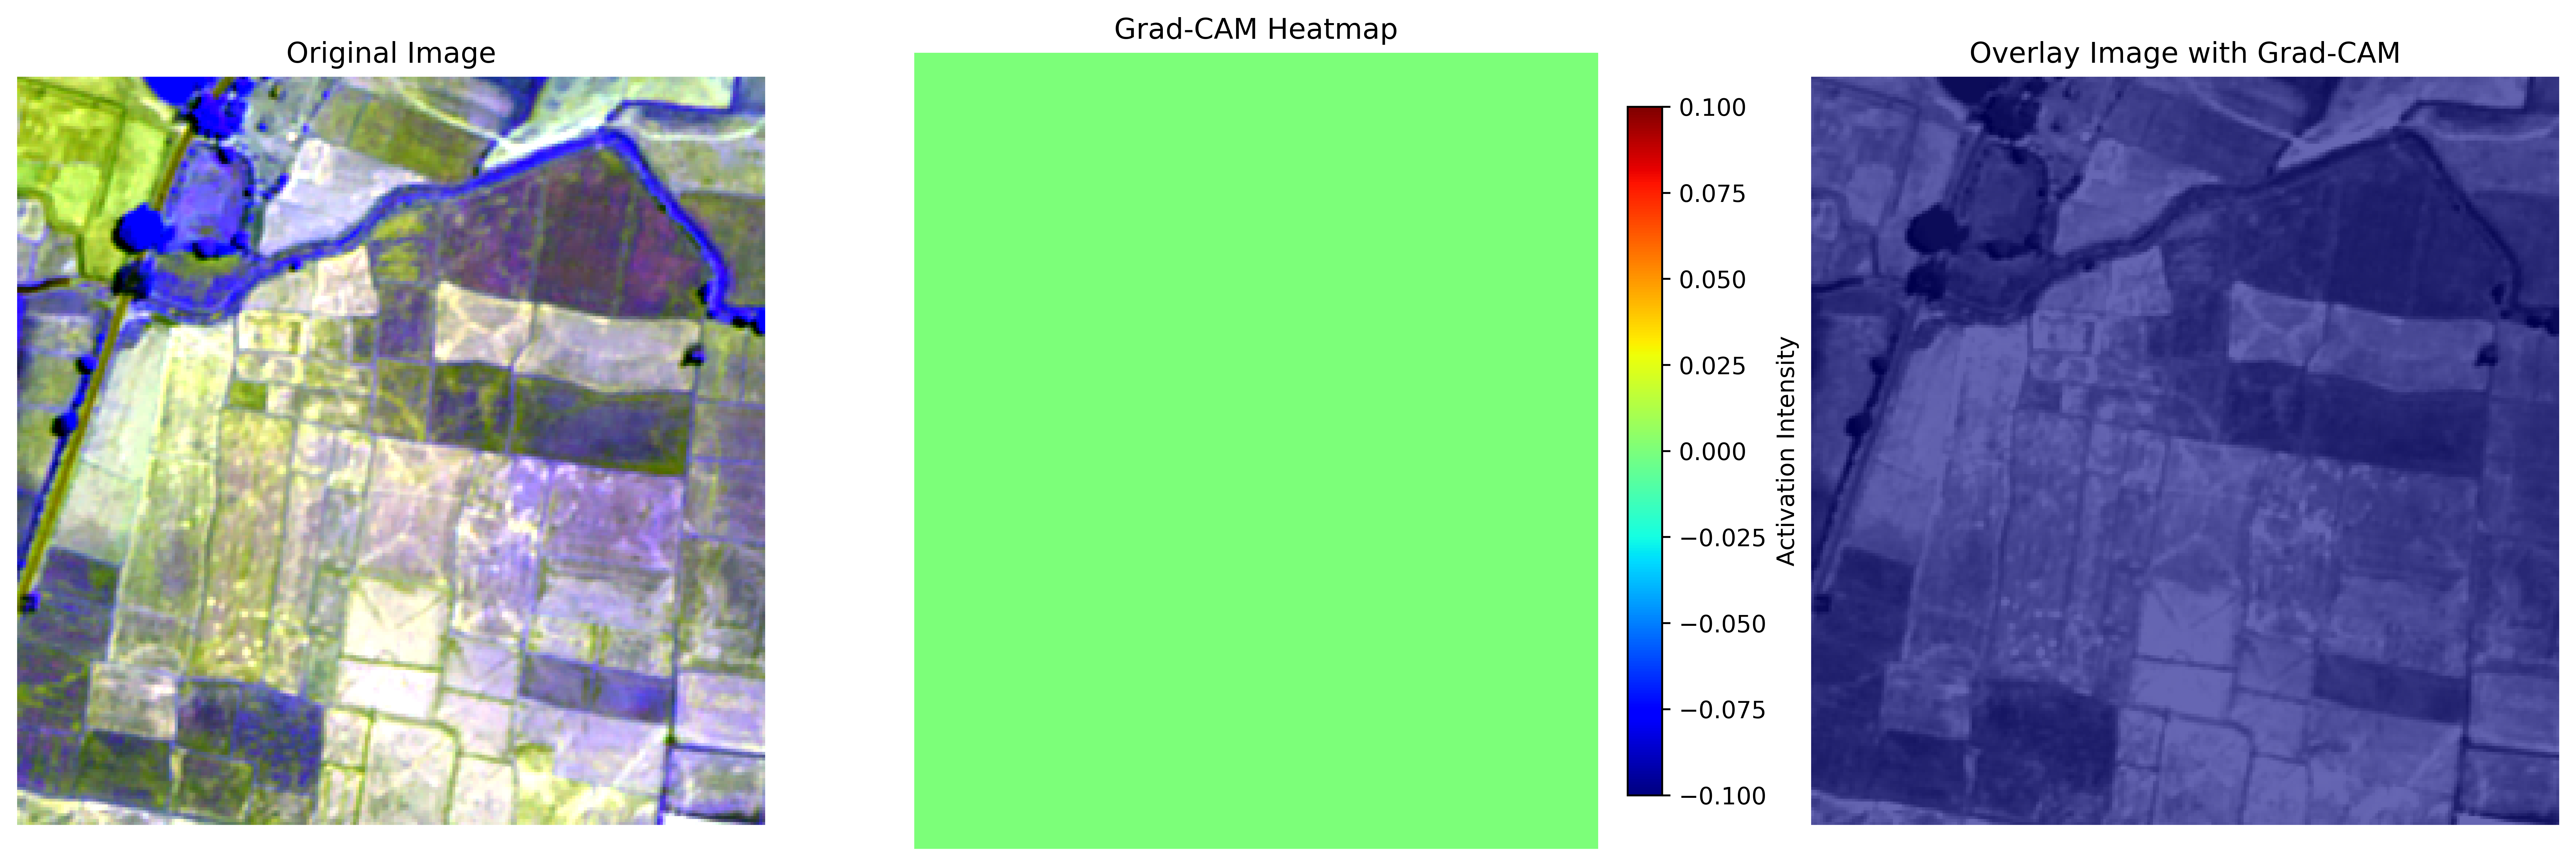

In [74]:
class_index = 0  # Replace with the index of the class you are interested in

plot_XAI(image_path, model, target_size, last_conv_layer_name, class_index)

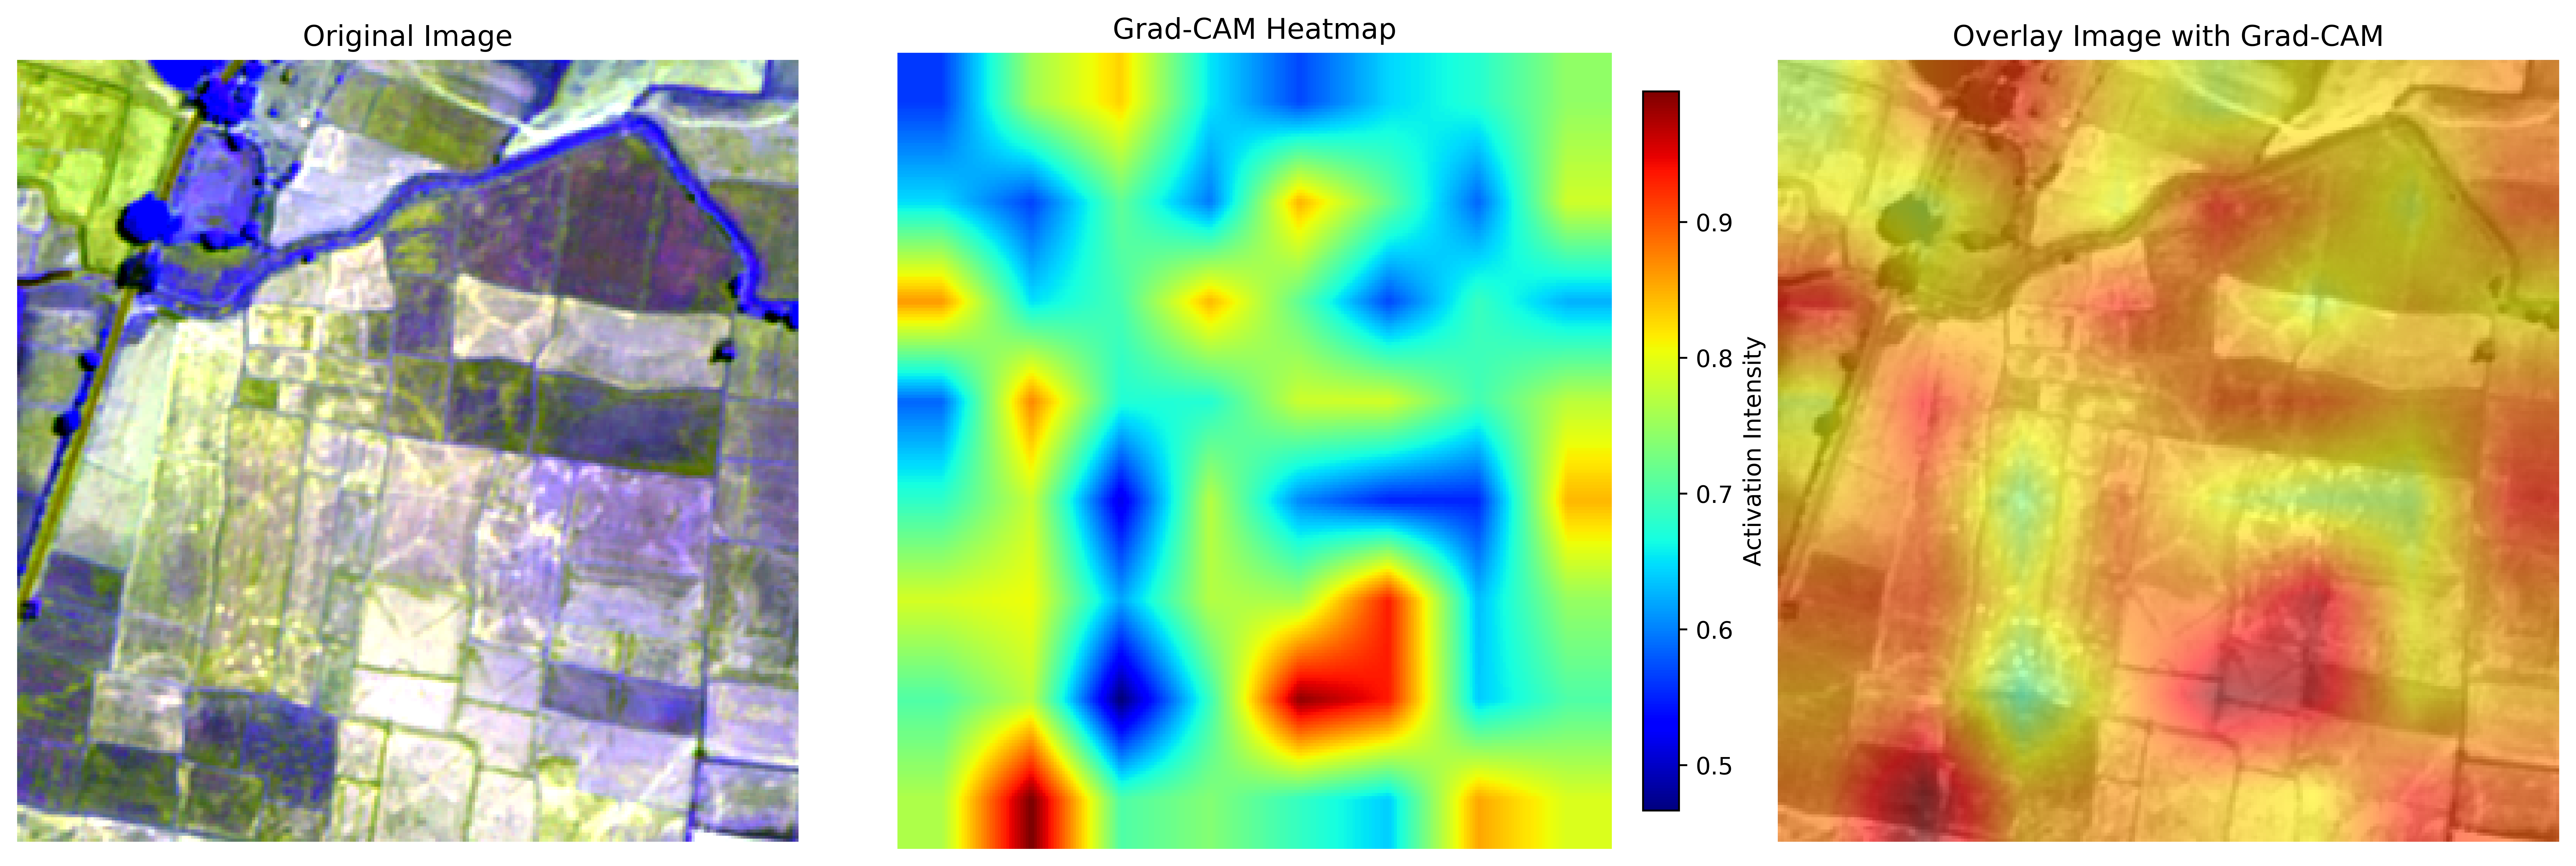

In [75]:
class_index = 1  # Replace with the index of the class you are interested in

plot_XAI(image_path, model, target_size, last_conv_layer_name, class_index)

In [ ]:
#boundary_heatmap = generate_gradcam(model, input_image, last_conv_layer_name, class_index=1)
#non_boundary_heatmap = generate_gradcam(model, input_image, last_conv_layer_name, class_index=0)

In [ ]:
#import matplotlib.pyplot as plt
#plt.imshow(boundary_heatmap, cmap='hot')  # Adjusted colormap for better visibility
#plt.colorbar()
#plt.show()

In [ ]:
# Overlay heatmap on original image while preserving alpha channel
output_image = overlay_heatmap(grayscale_image, boundary_heatmap, alpha_channel)

# Save or display the output image
#cv2.imwrite('output_image_boundary_heatmap.png', output_image)

In [ ]:
#import matplotlib.pyplot as plt
#plt.imshow(non_boundary_heatmap, cmap='hot')  # Adjusted colormap for better visibility
#plt.colorbar()
#plt.show()

In [ ]:
output_image = overlay_heatmap(grayscale_image,non_boundary_heatmap, alpha_channel)

# Save or display the output image
cv2.imwrite('output_image_non_boundary_heatmap.png', output_image)